# Gemini API: Multimodal Retrieval Augmented Generation (RAG)

In this notebook, you will learn how to perform RAG with multimodal embeddings. Here are the key objectives of this notebook:

1. Extract text, images, and tables from a PDF document.
2. Generate embeddings for these different types of data.
3. Compare the embeddigs to each other to answer questions.

## What is retrieval augmented generation (RAG)?

Retrieval augmented generation (RAG), is a way to use external data or information to improve the accuracy of large language models (LLMs).

## What is the difference between text-based embeddings and multimodal embeddings?

Text-based embeddings involves producing embeddings just for text. Multimodal embeddings comprise embedding different types of data, including images, audio, and video. The advantages of multimodal embeddings include:

1. **Enhanced knowledge access**: Multimodal embeddings capture information about textual and visual information, which provides a comprehensive knowledge base for an LLM.
2. **Improved reasoning capabilities**: By including visual information, multimodal RAG allows you to make better inferences across different types of data modalities.  

## What is Gemini?

Gemini is a family of generative AI models developed by Google DeepMind that is designed for multimodal use cases. Please visit this [link](https://ai.google.dev/gemini-api/docs/models/gemini) for more information on Gemini.

## Setup

Install and import the Gemini API, the appropriate LangChain tools, as well as third party libraries. When installing these dependencies, the versions specified in the installations commands work with each other. For consistency, we recommend keeping these version numbers for your own adaptations. You can find more information on the `unstructured` library installation [here](https://docs.unstructured.io/open-source/installation/full-installation).

In [ ]:
!pip install -U -q google-genai # Install the Gemini API Python SDK
!pip install -U -q "unstructured[all-docs]" # Unstructured library for parsing PDF upload
!pip install -U -q pypdf Pillow pydantic lxml pillow matplotlib opencv-python tiktoken # Install third party libraries

# Dependencies required by Unstructured PDF loader
!pip install --upgrade huggingface_hub # To extract images in hi-res
!sudo apt -y -qq install tesseract-ocr libtesseract-dev
!sudo apt-get -y -qq install poppler-utils
!pip install --user --quiet pytesseract==0.3.10 pdfminer.six==20221105
!pip install --upgrade onnxruntime==1.15.1

## Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [2]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Import the libraries

In [1]:
from google import genai
from google.genai import types

import os
import PIL
import textwrap
import numpy as np
import pandas as pd
from tqdm import tqdm
from pprint import pprint
from unstructured.partition.pdf import partition_pdf
from IPython.display import display, Image, Markdown

## Download the data

In [2]:
# Download documents and images used in this notebook
!gsutil cp gs://generativeai-downloads/data/med_gemini.pdf .
print("Download completed.")

Copying gs://generativeai-downloads/data/med_gemini.pdf...
/ [1 files][  6.5 MiB/  6.5 MiB]                                                
Operation completed over 1 objects/6.5 MiB.                                      
Download completed.


## Preprocessing

### Extract data from PDF

You will use the `unstructured` library to extract images, tables, and chunk text from our sample PDF file. Although it's a shorter document, the sample document still contains text along with images such as tables, charts, and graphs.

Please note that the images will be deposited in a separate directory called `figures/`. Specifically, the path in this notebook will be `/content/figures/`. You will be able to find all the images extracted in there. Please also note that capturing those images will cause the runtime of the cell below to be longer, and you must set `extract_images_in_pdf` to `True` and the `strategy` parameter must be `hi_res` in order to extract the images. For more information on extracting images from PDFs using the `unstructured` library, please check the [`partition_pdf` documentation](https://docs.unstructured.io/open-source/core-functionality/partitioning#partition-pdf).

In [3]:
pdf_file_path = '/content/med_gemini.pdf'

# Extract images, tables, and chunk text from the PDF file provided.
try:
  raw_pdf_elements = partition_pdf(
      filename=pdf_file_path,
      extract_images_in_pdf=True,
      infer_table_structure=True,
      chunking_strategy="by_title",
      max_characters=1000,
      combine_text_under_n_chars=250,
      strategy="hi_res",
  )
except PIL.UnidentifiedImageError:
  print("Could not identify image file.")

yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [4]:
len(raw_pdf_elements)

316

In [5]:
raw_pdf_elements[51].text # Display sample text extracted

'Uncertainty-guided search at inference We design a novel, uncertainty-guided and iterative search process to improve Med-Gemini-L 1.0’s generations at inference time. As displayed in the right panel of Figure 2, each iteration consists of four steps: multiple reasoning path generation, uncertainty-based search invocation, uncertainty-guided search query generation, and finally search retrieval for prompt augmentation. Note that while uncertainty-guided search at inference could potentially benefit multimodal settings, we only apply this approach to text-only benchmarks and leave multimodal exploration for future work.\n\n1. Multiple reasoning path generation: Given an input context prompt with a medical question, we generate multiple reasoning paths from Med-Gemini-L 1.0. For the first iteration, the prompt only consists of the instruction and question. For subsequent iterations, the prompt also includes search results from step (4) below.'

In [6]:
tables, texts = [], []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

In [7]:
tables[0] # Display a sample of the table extracted

'Task Dataset OOD Metric Med-Gemini-L 1.0 SoTA SoTA method Reference Close-ended QA Open-ended QA MedQa Accuracy 91.1 90.2 GPT-4 with MedPrompt —_Nori et al. (2023) NEJMCPC = ¥_Top-1 accuracy 30.7 29.2 AMIE McDuff et al. (2023) Top-10 accuracy 72.3 59.1 AMIE McDuff et al. (2023) Gene name extraction GeneTuring 7 ‘Accuracy 86.0 85.0 GPT4 Hou and Ji (2023) Gene alias GeneTuring VV Accuracy 72.7 66.0 GPr4 Hou and Ji (2023) Gene name conversion GeneTuring VV Accuracy 100.0 85.0 GPr4 Hou and Ji (2023) Gene location GeneTuring VV Accuracy 83.0 61.0 GPr4 Hou and Ji (2023) SNP location GeneTuring VV Accuracy 0.0 5.00 ChatGPT Hou and Ji (2023) Gene SNP association GeneTuring VV Accuracy 0.0 0.0 GPr4 Hou and Ji (2023) Protein-coding genes GeneTuring VV Accuracy 100.0 97.0 GPr4 Hou and Ji (2023) Gene disease association GeneTuring VV Accuracy 82.1 84.0 GPr4 Hou and Ji (2023) Gene ontology GeneTuring VV Accuracy 52.3 42.0 GPr4 Hou and Ji (2023)'

## Configure your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see  [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) for an example.

In [8]:
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

## Generate text and table summaries

You will use Gemini 2.0 (`gemini-2.0-flash-exp`) to generate summaries of text for the tabular and text data. Use the prompt below to generate the summaries of the inputs.

In [9]:
MODEL_NAME = "gemini-2.0-flash-exp" # Set the model to Gemini 2.0 Flash
client = genai.Client(api_key=GOOGLE_API_KEY)

In [10]:
def make_prompt(element):
  return f"""You are an agent tasked with summarizing research tables and texts from research papers for retrieval. \
             These summaries will be embedded and used to retrieve the raw text or table elements. \
             Give a concise summary of the tables or text that is well optimized for retrieval. Table or text: {element} """

def generate_text_summary(data):
  if len(data) >= 0:
    prompt = make_prompt(data)
    response = client.models.generate_content(
        model=MODEL_NAME,
        contents=prompt
    )
    return response.text

In [13]:
# Generate summaries for text elements
text_summaries = []
for text in tqdm(texts):
  text_summaries.append(generate_text_summary(text))

# Generate summaries for table elements
table_summaries = []
for table in tqdm(tables):
  table_summaries.append(generate_text_summary(table))

100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


Take a look at the original text compared to the summarized text:

In [14]:
pprint(f"Original text: {texts[51]}")
pprint("-"*100)
pprint(f"Summarized text: {text_summaries[51]}")

('Original text: Uncertainty-guided search at inference We design a novel, '
 'uncertainty-guided and iterative search process to improve Med-Gemini-L '
 '1.0’s generations at inference time. As displayed in the right panel of '
 'Figure 2, each iteration consists of four steps: multiple reasoning path '
 'generation, uncertainty-based search invocation, uncertainty-guided search '
 'query generation, and finally search retrieval for prompt augmentation. Note '
 'that while uncertainty-guided search at inference could potentially benefit '
 'multimodal settings, we only apply this approach to text-only benchmarks and '
 'leave multimodal exploration for future work.\n'
 '\n'
 '1. Multiple reasoning path generation: Given an input context prompt with a '
 'medical question, we generate multiple reasoning paths from Med-Gemini-L '
 '1.0. For the first iteration, the prompt only consists of the instruction '
 'and question. For subsequent iterations, the prompt also includes search '
 're

Take a look at the original table compared to the summarized table:

In [15]:
pprint(f"Original table: {tables[3]}")
pprint("-"*100)
pprint(f"Summarized table: {table_summaries[3]}")

('Original table: BMC Cell Biology Brain dystrophin-glycoprotein complex: '
 'persistent expression of B-dystroglycan, impaired oligomerization of Dp71 '
 'and up-regulation of utrophins in animal models of muscular dystrophy '
 'Culligan, K., Glover, L., Dowling, P., & Ohlendieck, K. International '
 'Journal of Biological Sciences Complex relationship between obesity and the '
 'fat mass and obesity locus. Yang, Q., Xiao, T., Guo, J., & Su, Z. Frontiers '
 'in Endocrinology Critical enzymatic functions of FTO in obesity and cancer '
 'Deng, X., Su, R., Stanford, S., & Chen, J. Current Diabetes Reports The '
 'American Journal of Clinical Nutrition New England Journal of Medicine FTO '
 'and obesity: mechanisms of association. FTO genotype impacts food intake and '
 'corticolimbic activation FTO obesity variant circuitry and adipocyte '
 'browning in humans. New England Journal of Medicine')
'---------------------------------------------------------------------------------------------

### Generate image summaries

In the code cell below, you will use a prompt to input an image and generate a text summary of that image. The `gemini-1.5-flash` model will be used to accomplish this as well.

Encoding an image is important to protect the image data while storing and retrieving it.

In [16]:
def generate_image_summaries(image_paths):
  image_summaries = [] # Store image summaries

  prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval.
    If it's a table, extract all elements of the table.
    If it's a graph, explain the findings in the graph.
    Include details about color, proportion, and shape if necessary to describe the image. \
    Do not include any numbers that are not mentioned in the image.
    """

  for image_path in tqdm(image_paths):
    img = PIL.Image.open(image_path.path)
    response = client.models.generate_content(
        model=MODEL_NAME,
        contents=[prompt, img]
        )
    image_summaries.append(response.text)

  return image_summaries

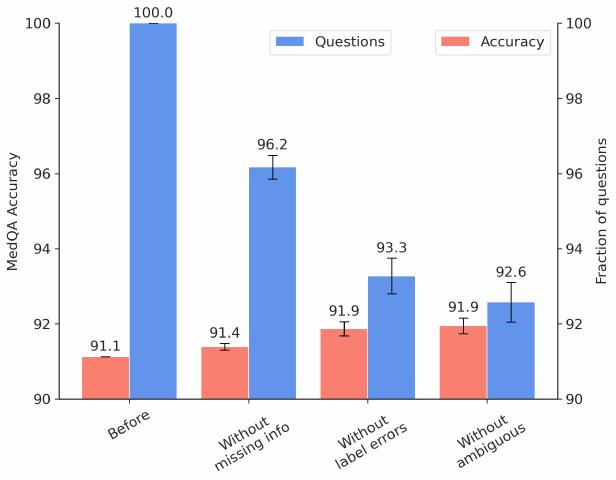

In [18]:
# Take look at one of the images
img = PIL.Image.open(f"/content/figures/{os.listdir('/content/figures/')[0]}")
display(img)

In [19]:
image_summaries = generate_image_summaries(os.scandir('/content/figures/'))

76it [01:52,  1.48s/it]


In [20]:
image_summaries[0]

'The image is a bar graph showing the performance of a MedQA system under different conditions. The x-axis represents four conditions: "Before", "Without missing info", "Without label errors", and "Without ambiguous". There are two y-axes, the left one represents "MedQA Accuracy" and the right one "Fraction of questions". Blue bars represent "Questions" and red bars represent "Accuracy". The bars show that the accuracy of the system increases when the system operates "Without missing info" compared to "Before". The fraction of questions reduces in the remaining conditions "Without label errors" and "Without ambiguous". The largest fraction of questions is when the system operates "Before" at 100.'

## Embedding generation

Generate embeddings for the texts, tables, and images now. Store them in the Pandas dataframe for now.

### API changes to Embeddings with model embedding-001

For the new embeddings model, `embedding-001`, there is a new `task type` parameter and the optional title (only valid with task_type=`RETRIEVAL_DOCUMENT`).

These new parameters apply only to the newest embeddings models.The task types are:

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.

In [26]:
TEXT_EMBEDDING_MODEL_ID = "text-embedding-004"

In [43]:
!pip install ratelimit

  Preparing metadata (setup.py) ... done
  Created wheel for ratelimit: filename=ratelimit-2.2.1-py3-none-any.whl size=5895 sha256=723f7733f5e4a406bc7e73d87bdede3d40cd3a62a069d64f73583744cfe49e5e
  Stored in directory: /root/.cache/pip/wheels/27/5f/ba/e972a56dcbf5de9f2b7d2b2a710113970bd173c4dcd3d2c902
Successfully built ratelimit


In [44]:
import time
from ratelimit import limits, sleep_and_retry

# Define a rate limit decorator with 60 requests per minute
@sleep_and_retry
@limits(calls=60, period=60)
def create_embeddings(data):
  time.sleep(1)
  return client.models.embed_content(model=TEXT_EMBEDDING_MODEL_ID,
                                     contents=data,
                                     config=types.EmbedContentConfig(
                                         task_type="RETRIEVAL_DOCUMENT"
                                      )
  )

In [33]:
# Generate embeddings for text summaries, and add to the dataframe.
data_df = pd.DataFrame(columns=['Original Text or Image', 'Summary', 'Embeddings']) # Create new Pandas dataframe
data_df['Original Text or Image'] = texts + tables + [img.path for img in os.scandir('/content/figures/')]
data_df['Summary'] = text_summaries + table_summaries + image_summaries
data_df = data_df[data_df['Original Text or Image'] != ''] # Drop empty entries
data_df

,Original Text or Image,Summary,Embeddings
0,4\n\n2024\n\n2\n\n0\n\n2 y a M 1 ] I A . s c [...,This is a header section indicating the origin...,NaN
1,"Khaled Saab◦,1, Tao Tu◦,‡,1, Wei-Hung Weng◦,1,...",This is a list of authors and their affiliatio...,NaN
2,"Joelle Barral2, Greg Corrado1, Christopher Sem...",This text lists the authors of a research pape...,NaN
3,"◦Co-first, *Core, ‡Technical Lead, †Senior Lea...",This text lists author affiliations and roles....,NaN
4,Excellence in a wide variety of medical applic...,"Med-Gemini models, specialized in medicine, ou...",NaN
...,...,...,...
387,/content/figures/figure-26-26.jpg,A black outline of a person icon. The person i...,NaN
388,/content/figures/figure-2-7.jpg,"A digital illustration of a tablet screen, sho...",NaN
389,/content/figures/figure-2-6.jpg,This image shows a light-blue mobile phone scr...,NaN
390,/content/figures/figure-27-40.jpg,"The image shows a simple, black-line drawing o...",NaN


In [48]:
# Generate embeddings one at a time for each row of dataframe
embeddings = []
try:
  for text in tqdm(data_df['Summary']):
    embeddings.append(create_embeddings(text))
except:
  time.sleep(10)


100%|██████████| 392/392 [09:00<00:00,  1.38s/it]


In [70]:
_embeddings = []
for embedding in embeddings:
  _embeddings.append(embedding.embeddings[0].values)


data_df['Embeddings'] = _embeddings

In [71]:
data_df.head()

,Original Text or Image,Summary,Embeddings
0,4\n\n2024\n\n2\n\n0\n\n2 y a M 1 ] I A . s c [...,This is a header section indicating the origin...,"[0.055964004, 0.03846679, -0.049835, 0.0494487..."
1,"Khaled Saab◦,1, Tao Tu◦,‡,1, Wei-Hung Weng◦,1,...",This is a list of authors and their affiliatio...,"[-0.0016375299, 0.027570048, -0.07061442, 0.05..."
2,"Joelle Barral2, Greg Corrado1, Christopher Sem...",This text lists the authors of a research pape...,"[-0.009014637, 0.00067063654, -0.032143217, 0...."
3,"◦Co-first, *Core, ‡Technical Lead, †Senior Lea...",This text lists author affiliations and roles....,"[0.041981556, 0.026378741, -0.059118178, 0.016..."
4,Excellence in a wide variety of medical applic...,"Med-Gemini models, specialized in medicine, ou...","[0.04048051, 0.01800591, -0.050974954, -0.0095..."


## Embedding search with queries

In [72]:
query1 = "What is Med-Gemini?"
query2 = "What are some areas of improvement for LLM performance mentioned in this paper?"
query3 = "How does the MedQA evaluation work?"
query4 = "What do the hypothetical multimodal medical dialogues demonstrate about Med-Gemini?"
query5 = "What are some challenges and opportunities for applying LLMs to clinical problems?"
query6 = "What models are Med-Gemini benchmarked against?"

queries = [query1, query2, query3, query4, query5, query6]

Use the `find_best_passage` function to calculate the dot products, and then sort the dataframe from the largest to smallest dot product value to retrieve the relevant passage out of the database. Embed the queries as well so you can perform a search against the database of knowlege.

In [79]:
def find_best_passage(query, dataframe):
  """
  Compute the distances between the query and each document in the dataframe
  using the dot product.
  """
  query_embedding = client.models.embed_content(model=TEXT_EMBEDDING_MODEL_ID,
                                        contents=query,
                                        config=types.EmbedContentConfig(task_type="RETRIEVAL_QUERY")
                                        )
  dot_products = np.dot(np.stack(dataframe['Embeddings']), query_embedding.embeddings[0].values)
  idx = np.argmax(dot_products)
  return dataframe.iloc[idx]['Original Text or Image'] # Return text from index with max value

Here is an example of the retrieval.

In [80]:
passage = find_best_passage(query1, data_df)
pprint(passage)

('potential for multimodal medical dialogue, medical research and education. '
 'Taken together, our results offer compelling evidence for the promise of '
 'Med-Gemini in many areas of medicine, although further rigorous evaluation '
 'will be crucial before real-world deployment in this safety-critical domain.')


## Summarization

Now use `generate_content` once more to generate answers to the queries posed earlier.

In [81]:
def make_prompt(query, relevant_passage):
  escaped = relevant_passage.replace("'", "").replace('"', "").replace("\n", " ")
  prompt = textwrap.dedent("""You are a helpful and informative bot that answers questions using text from the reference passage included below. \
  You are answering questions about a research paper. \
  Be sure to respond in a complete sentence, being comprehensive, including all relevant background information. \
  However, you are talking to a non-technical audience, so be sure to break down complicated concepts and \
  strike a friendly and converstional tone. \
  If the passage is irrelevant to the answer, you may ignore it.
  QUESTION: '{query}'
  PASSAGE: '{relevant_passage}'

    ANSWER:
  """).format(query=query, relevant_passage=escaped)

  return prompt

In [82]:
prompt = make_prompt(query1, passage)
pprint(prompt)

('You are a helpful and informative bot that answers questions using text from '
 'the reference passage included below.   You are answering questions about a '
 'research paper.   Be sure to respond in a complete sentence, being '
 'comprehensive, including all relevant background information.   However, you '
 'are talking to a non-technical audience, so be sure to break down '
 'complicated concepts and   strike a friendly and converstional tone.   If '
 'the passage is irrelevant to the answer, you may ignore it.\n'
 "  QUESTION: 'What is Med-Gemini?'\n"
 "  PASSAGE: 'potential for multimodal medical dialogue, medical research and "
 'education. Taken together, our results offer compelling evidence for the '
 'promise of Med-Gemini in many areas of medicine, although further rigorous '
 'evaluation will be crucial before real-world deployment in this '
 "safety-critical domain.'\n"
 '\n'
 '    ANSWER:\n')


In [83]:
# For each query in the list, generate a list of passages
passages = [find_best_passage(query, data_df) for query in queries]

In [84]:
prompts = [make_prompt(query, passage) for query, passage in zip(queries, passages)]

In [85]:
# Generate Markdown of the response.text from `generate_content` when passing in the information
responses = [client.models.generate_content(model=MODEL_NAME,
                                            contents=prompt) for prompt in prompts]

for response, query in zip(responses, queries):
  display(Markdown(f"**{query}**")) # Make query bold in Markdown
  display(Markdown(response.text))

**What is Med-Gemini?**

Based on the passage provided, Med-Gemini is a tool with potential in various areas of medicine, such as multimodal medical dialogue, medical research, and education; however, the passage indicates that further evaluation is necessary before it can be used in real-world situations.


**What are some areas of improvement for LLM performance mentioned in this paper?**

Okay, so it looks like this research paper is discussing ways to make large language models (LLMs) better, especially when it comes to medical applications. The authors mention a few areas where LLMs could really improve. First, they point out that LLMs sometimes struggle with "clinical reasoning under uncertainty," which means they aren't always great at making decisions when things aren't clear-cut. They also mention that LLMs can sometimes "confabulate" or make things up, and they can show bias in their responses. Another area for improvement is using tools and up-to-date medical information, which is key in the medical field. They also need to get better at collaborating with doctors and other clinicians. Finally, LLMs could get much better at handling different types of medical data, such as images, videos, and patient records over time. So, to summarize, the paper suggests that LLMs need improvement in clinical reasoning under uncertainty, avoiding confabulation and bias, using tools and up-to-date information, collaborating with clinicians, and handling multimodal data.


**How does the MedQA evaluation work?**

Okay, so the MedQA evaluation is a bit like a detailed quiz review, where experts look at each question and answer option very carefully to see if they make sense. It's done in two steps. First, for each question, the experts are asked if there are any appropriate answers given the options. If yes, they pick the answer they think is correct. They also check if there's any missing information, like a graph or lab result, and if having that information would change their answer. After the experts have gone through these questions, in the second step, they're shown the original correct answer to see if they agree. This helps the researchers identify if the questions are clear, if the answer is right, and if any additional info is needed.


**What do the hypothetical multimodal medical dialogues demonstrate about Med-Gemini?**

Based on the provided passage, the hypothetical multimodal medical dialogues demonstrate the potential of Med-Gemini in areas like medical research and education, suggesting that it could be a helpful tool for these purposes.


**What are some challenges and opportunities for applying LLMs to clinical problems?**

Okay, so when we think about using powerful language models, also known as LLMs, in healthcare, there are some really exciting possibilities, but also some hurdles to overcome. The research paper highlights that while LLMs show promise in clinical applications, they sometimes struggle with complex medical decision-making, especially when things are uncertain. They can also make things up or show biases, which is obviously a big concern in medicine.  Another challenge is making sure LLMs can use up-to-date medical information and work well with doctors. Finally, LLMs currently have difficulty handling different kinds of medical information together, like images, videos, and patient records. However, it's not all challenges because working to solve these problems could improve language models in general, not just in healthcare!


**What models are Med-Gemini benchmarked against?**

The research paper mentions that the study considered 14 different benchmarks, but it doesn't specify which specific models were used for comparison against Med-Gemini. It does note that there are over 350 medical benchmarks available for the community to use. So, while the paper is talking about benchmarks, it doesn't actually specify what models they are benchmarking Med-Gemini against.
